In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import (train_test_split, StratifiedKFold, cross_validate)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Suppress overflow warnings from sklearn/numpy
warnings.filterwarnings("ignore", category=RuntimeWarning)
np.seterr(over='ignore')

sns.set(style='whitegrid', context='notebook')

#Check device for NN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
df = pd.read_csv('ECGCvdata 2.csv') #replace obv
df.shape

(1200, 56)

In [4]:
df.head()

,RECORD,hbpermin,Pseg,PQseg,QRSseg,QRseg,QTseg,RSseg,STseg,Tseg,...,RMSSD,QRSarea,QRSperi,PQslope,QRslope,RSslope,STslope,NN50,pNN50,ECG_signal
0,1,74.925669,0.076508,0.108889,0.088254,0.043571,0.193016,0.044683,0.104762,0.130476,...,292.296636,18.457618,63.615239,-0.014364,0.075270,-0.070846,0.012606,2,5.882353,ARR
1,2,68.503469,0.072483,0.096181,0.093924,0.046267,0.193490,0.047656,0.099566,0.089149,...,318.563915,23.043230,67.787773,-0.021207,0.083773,-0.077458,0.016175,1,3.225806,ARR
2,3,83.488603,0.071154,0.086610,0.039530,0.018590,0.132479,0.020940,0.092949,0.094444,...,273.165412,10.756353,29.253827,-0.042542,NaN,NaN,0.027131,16,42.105263,ARR
3,4,68.503469,0.082812,0.108160,0.090365,0.045226,0.188802,0.045139,0.098437,0.088281,...,313.046941,23.845086,65.228737,-0.017806,0.091591,-0.088559,0.017022,2,6.451613,ARR
4,5,82.080000,0.070760,0.102632,0.101023,0.049415,0.193713,0.051608,0.092690,0.085965,...,263.225676,20.942791,72.830353,-0.016650,0.064547,-0.062246,0.016191,2,5.405405,ARR


In [5]:
df.isnull().sum()

RECORD          0
hbpermin        0
Pseg            0
PQseg           0
QRSseg          0
QRseg           0
QTseg           0
RSseg           0
STseg           0
Tseg            0
PTseg           0
ECGseg          0
QRtoQSdur     769
RStoQSdur     769
RRmean          0
PPmean          0
PQdis           0
PonQdis         0
PRdis           0
PonRdis         0
PSdis           0
PonSdis         0
PTdis           0
PonTdis         0
PToffdis        0
QRdis           0
QSdis           0
QTdis           0
QToffdis        0
RSdis           0
RTdis           0
RToffdis        0
STdis           0
SToffdis        0
PonToffdis      0
PonPQang      557
PQRang        768
QRSang        769
RSTang        769
STToffang     426
RRTot           0
NNTot           0
SDRR            0
IBIM            0
IBISD           0
SDSD            0
RMSSD           0
QRSarea         0
QRSperi         0
PQslope         0
QRslope       768
RSslope       769
STslope         0
NN50            0
pNN50           0
ECG_signal

In [6]:
# Noticing a lot of NULLS with some entries not having complete data, we will see how valid those stats are 
# And decide if we are able to drop them 

In [7]:
# 1) Drop columns with >50% missing
missing_pct = (df.isnull().sum() / len(df)) * 100
high_missing_cols = missing_pct[missing_pct > 50].index.tolist()
df_clean = df.drop(columns=high_missing_cols)

In [8]:
# Find outliers 
num_features = df.select_dtypes(include='number').columns
outliers_list = []

for col in num_features:
    Q1 = df[col].quantile(0.25)
    median = df[col].median()
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    outliers_list.append([col, len(outliers)])

for col_name, outlier_count in outliers_list:
    print(f"{col_name}: {outlier_count} outliers")

RECORD: 0 outliers
hbpermin: 14 outliers
Pseg: 18 outliers
PQseg: 0 outliers
QRSseg: 0 outliers
QRseg: 0 outliers
QTseg: 0 outliers
RSseg: 0 outliers
STseg: 148 outliers
Tseg: 98 outliers
PTseg: 0 outliers
ECGseg: 0 outliers
QRtoQSdur: 0 outliers
RStoQSdur: 0 outliers
RRmean: 24 outliers
PPmean: 24 outliers
PQdis: 5 outliers
PonQdis: 2 outliers
PRdis: 0 outliers
PonRdis: 0 outliers
PSdis: 0 outliers
PonSdis: 0 outliers
PTdis: 0 outliers
PonTdis: 0 outliers
PToffdis: 0 outliers
QRdis: 0 outliers
QSdis: 0 outliers
QTdis: 0 outliers
QToffdis: 0 outliers
RSdis: 0 outliers
RTdis: 0 outliers
RToffdis: 1 outliers
STdis: 2 outliers
SToffdis: 5 outliers
PonToffdis: 0 outliers
PonPQang: 31 outliers
PQRang: 0 outliers
QRSang: 0 outliers
RSTang: 0 outliers
STToffang: 29 outliers
RRTot: 5 outliers
NNTot: 0 outliers
SDRR: 99 outliers
IBIM: 48 outliers
IBISD: 71 outliers
SDSD: 104 outliers
RMSSD: 30 outliers
QRSarea: 0 outliers
QRSperi: 0 outliers
PQslope: 0 outliers
QRslope: 0 outliers
RSslope: 0 ou

In [9]:
# With these results its clear we should fill NaNs with median not mean

# Fill NaNs left with median
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

In [10]:
#Show different results for ECG_signal
print(sorted(df['ECG_signal'].unique().tolist()))
# AFF = Atrial Fibrillation: Rapid irregular atrial activity
# ARR = Arrhythmia: Abnormal Rhytms aren't speficially labeled
# CHF = Congestive Heart Failure: Not rhytm but heart fail;ure
# NSR = Normal Sinus Rhythm: healthy regular heartbeat

['AFF', 'ARR', 'CHF', 'NSR']


In [11]:
# 
df_encoded = pd.get_dummies(df, columns=['ECG_signal'], dtype=int)
df_encoded.sum()

RECORD            720600.000000
hbpermin           98272.776075
Pseg                  73.082444
PQseg                 93.719023
QRSseg                57.885235
QRseg                 29.324903
QTseg                169.849209
RSseg                 28.560332
STseg                111.963973
Tseg                 123.256759
PTseg                263.568231
ECGseg               356.592907
QRtoQSdur              1.059356
RStoQSdur              1.045123
RRmean            231114.202342
PPmean            231094.044061
PQdis              23049.527807
PonQdis            32085.741286
PRdis              30276.172202
PonRdis            39316.865222
PSdis              37340.498572
PonSdis            46378.870410
PTdis              65156.208838
PonTdis            74225.433921
PToffdis           79331.910139
QRdis               7280.302738
QSdis              14294.925229
QTdis              42170.051629
QToffdis           56340.819602
RSdis               7123.787308
RTdis              34943.751666
RToffdis

In [12]:
df_encoded.head()

,RECORD,hbpermin,Pseg,PQseg,QRSseg,QRseg,QTseg,RSseg,STseg,Tseg,...,PQslope,QRslope,RSslope,STslope,NN50,pNN50,ECG_signal_AFF,ECG_signal_ARR,ECG_signal_CHF,ECG_signal_NSR
0,1,74.925669,0.076508,0.108889,0.088254,0.043571,0.193016,0.044683,0.104762,0.130476,...,-0.014364,0.075270,-0.070846,0.012606,2,5.882353,0,1,0,0
1,2,68.503469,0.072483,0.096181,0.093924,0.046267,0.193490,0.047656,0.099566,0.089149,...,-0.021207,0.083773,-0.077458,0.016175,1,3.225806,0,1,0,0
2,3,83.488603,0.071154,0.086610,0.039530,0.018590,0.132479,0.020940,0.092949,0.094444,...,-0.042542,NaN,NaN,0.027131,16,42.105263,0,1,0,0
3,4,68.503469,0.082812,0.108160,0.090365,0.045226,0.188802,0.045139,0.098437,0.088281,...,-0.017806,0.091591,-0.088559,0.017022,2,6.451613,0,1,0,0
4,5,82.080000,0.070760,0.102632,0.101023,0.049415,0.193713,0.051608,0.092690,0.085965,...,-0.016650,0.064547,-0.062246,0.016191,2,5.405405,0,1,0,0


In [13]:
feature_list = ['RRmean', 'PPmean', 'RTdis', 'PonTdis', 'PonToffdis', 'QTdis',
                'IBIM', 'NN50', 'hbpermin', 'RSslope', 'RRTot', 'NNTot', 'STslope']

feature_list = [c for c in feature_list if c in df_encoded.columns]

In [14]:
# Linear regression R^2 for EACH class (using your feature_list)
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

X = df_encoded[feature_list]
label_cols = [c for c in df_encoded.columns if c.startswith('ECG_signal_')]

pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    LinearRegression()
)

r2_table = []

for lab in label_cols:
    y = df_encoded[lab].astype(float)
    mask = y.notna()               # (y should be clean, but keep it consistent)
    X_use = X.loc[mask]
    y_use = y.loc[mask]
    if y_use.nunique() <= 1:       # constant target => R² undefined
        r2 = np.nan
    else:
        pipe.fit(X_use, y_use)
        r2 = pipe.score(X_use, y_use)
    r2_table.append((lab, r2))

# Show R^2 sorted (highest first)
r2_table = sorted(r2_table, key=lambda x: x[1], reverse=True)
r2_table

[('ECG_signal_NSR', 0.9471558372582268),
 ('ECG_signal_ARR', 0.8003051696057338),
 ('ECG_signal_CHF', 0.49182983171543637),
 ('ECG_signal_AFF', 0.4544285744150258)]

In [15]:
# As we can tell the regular one is MUCH higher than the rest.
# Adding a proper classifier + CV AUC

In [16]:
# See which features were dropped and which remain
set(['RRmean','PPmean','RTdis','PonTdis','PonToffdis','QTdis','IBIM','NN50','hbpermin','RSslope','RRTot','NNTot','STslope']) - set(df_encoded.columns)

# Confirm X is clean *after* imputation is applied in the pipeline (no need to impute here)
df_encoded[feature_list].isna().sum().sort_values(ascending=False).head(10)

# Check label balance
df_encoded[label_cols].sum()


ECG_signal_AFF    300
ECG_signal_ARR    300
ECG_signal_CHF    300
ECG_signal_NSR    300
dtype: int64

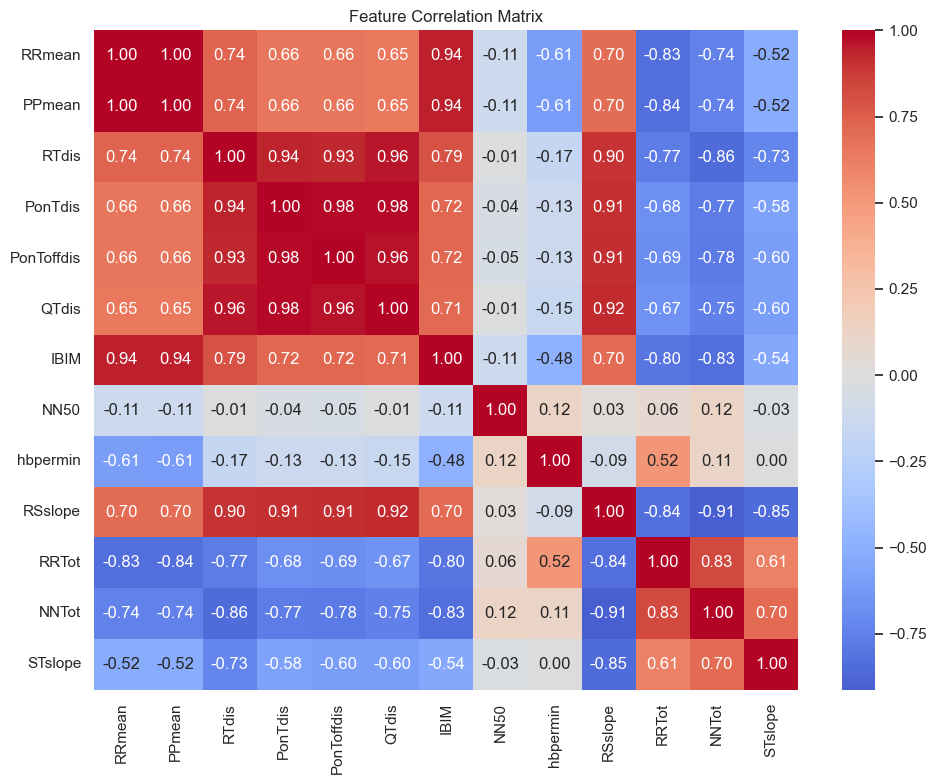

Highly correlated features (>0.9):
RRmean <-> PPmean: 1.000
RRmean <-> IBIM: 0.944
PPmean <-> IBIM: 0.944
RTdis <-> PonTdis: 0.938
RTdis <-> PonToffdis: 0.933
RTdis <-> QTdis: 0.958
RTdis <-> RSslope: 0.901
PonTdis <-> PonToffdis: 0.981
PonTdis <-> QTdis: 0.979
PonTdis <-> RSslope: 0.906
PonToffdis <-> QTdis: 0.964
PonToffdis <-> RSslope: 0.911
QTdis <-> RSslope: 0.918
RSslope <-> NNTot: -0.912


In [17]:
# Check correlations among features
corr_matrix = df_encoded[feature_list].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Find highly correlated pairs (>0.9)
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
print("Highly correlated features (>0.9):")
for feat1, feat2, corr in high_corr:
    print(f"{feat1} <-> {feat2}: {corr:.3f}")

In [18]:
# Dropping PPmean as same hting as RRMean
features_final = [f for f in feature_list if f not in ['PPmean',]]

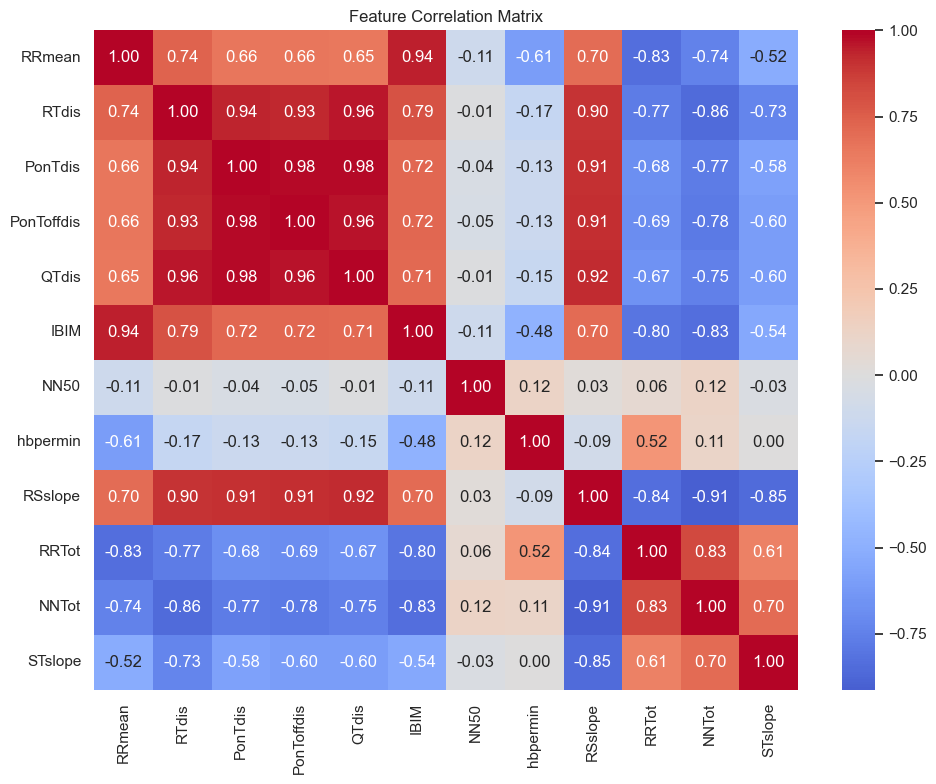

Highly correlated features (>0.9):
RRmean <-> IBIM: 0.944
RTdis <-> PonTdis: 0.938
RTdis <-> PonToffdis: 0.933
RTdis <-> QTdis: 0.958
RTdis <-> RSslope: 0.901
PonTdis <-> PonToffdis: 0.981
PonTdis <-> QTdis: 0.979
PonTdis <-> RSslope: 0.906
PonToffdis <-> QTdis: 0.964
PonToffdis <-> RSslope: 0.911
QTdis <-> RSslope: 0.918
RSslope <-> NNTot: -0.912


In [19]:
# Check correlations among features
corr_matrix = df_encoded[features_final].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Find highly correlated pairs (>0.9)
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
print("Highly correlated features (>0.9):")
for feat1, feat2, corr in high_corr:
    print(f"{feat1} <-> {feat2}: {corr:.3f}")

In [20]:
# Train/Val/Test Split

X = df_encoded[features_final]
y = df_encoded[label_cols].values

y_labels = df_encoded[label_cols].idxmax(axis=1).str.replace('ECG_Signal_','')

# Spliting: 60% train, 20% val, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_labels, test_size=0.4, stratify=y_labels, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
print(f"Train distribution:\n{y_train.value_counts()}")

Train: 720, Val: 240, Test: 240
Train distribution:
ECG_signal_AFF    180
ECG_signal_CHF    180
ECG_signal_NSR    180
ECG_signal_ARR    180
Name: count, dtype: int64


In [21]:
# One note is that RRmean and PPmean being 1 is not a red flag, but should not be used 
# To train the model 

In [22]:
## Evaluation HELPER function to give accuracy for P/R/F1 scores -> Useful for model training


In [23]:
def evaluate_model(name, pipeline, X_tr, y_tr, X_va, y_va):
    pipeline.fit(X_tr, y_tr)

    # Predictions
    y_tr_pred = pipeline.predict(X_tr)
    y_va_pred = pipeline.predict(X_va)

    # Accuracy
    acc_tr = accuracy_score(y_tr, y_tr_pred)
    acc_va = accuracy_score(y_va, y_va_pred)

    # Macro P/R/F1 (Equally weighted)
    p_va, r_va, f1_va, _ = precision_recall_fscore_support(
        y_va, y_va_pred, average='macro', zero_division=0
    )
    
    # Weighted P/R/F1 (accounts for class support)
    p_weighted, r_weighted, f1_weighted, _ = precision_recall_fscore_support(
        y_va, y_va_pred, average='weighted', zero_division=0
    )

    print(f"\n=== {name} ===")
    print(f"Train accuracy: {acc_tr:.3f}")
    print(f"Val accuracy:   {acc_va:.3f}")
    print(f"Val macro P/R/F1: {p_va:.3f} / {r_va:.3f} / {f1_va:.3f}")
    print(f"Val weighted P/R/F1: {p_weighted: .3f} / {r_weighted:.3f} / {f1_weighted:.3f}")

    # Confusion matrix
    labels_sorted = sorted(y_va.unique())
    print("Labels order:", labels_sorted)
    print("Val confusion matrix:\n",
          confusion_matrix(y_va, y_va_pred, labels=labels_sorted))
    
    print("\nPer-class classification report:\n",
          classification_report(y_va, y_va_pred, digits=3, zero_division=0))

    return pipeline

In [24]:
# Model 1
# Logistic Regression baseline linear classifer
# Classic ML baseline, imputation + standardization

log_reg_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        max_iter = 1000,
        multi_class = 'multinomial'
    ))
])

log_reg_pipeline = evaluate_model(
    "Logistic Regression",
    log_reg_pipeline,
    X_train, y_train,
    X_val, y_val
)


=== Logistic Regression ===
Train accuracy: 0.953
Val accuracy:   0.938
Val macro P/R/F1: 0.942 / 0.938 / 0.937
Val weighted P/R/F1:  0.942 / 0.938 / 0.937
Labels order: ['ECG_signal_AFF', 'ECG_signal_ARR', 'ECG_signal_CHF', 'ECG_signal_NSR']
Val confusion matrix:
 [[48  0 12  0]
 [ 0 60  0  0]
 [ 3  0 57  0]
 [ 0  0  0 60]]

Per-class classification report:
                 precision    recall  f1-score   support

ECG_signal_AFF      0.941     0.800     0.865        60
ECG_signal_ARR      1.000     1.000     1.000        60
ECG_signal_CHF      0.826     0.950     0.884        60
ECG_signal_NSR      1.000     1.000     1.000        60

      accuracy                          0.938       240
     macro avg      0.942     0.938     0.937       240
  weighted avg      0.942     0.938     0.937       240



/Users/hamzakhamissa/opt/anaconda3/envs/DS3000env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [25]:
## Interpreting the confusion matrix 
# 60 Sampels per class in validation (240 total)
# AFF: 48/60 correct (80%)
# ARR: 60/60 correct (100%)
# CHF: 57/60 correct (95%)
# NSR: 60/60 correct (100%)

# Not bad, but when it coems to life-or-death situations we don't want any level of risk
# Let's see if we can do better


## Note
#the linear model is unable to reliably distinguish between AFF and CHF, misclassifying 20% of AFF cases??


In [26]:
# Random Forest 

rf_pipeline = Pipeline ([
    ('imputer', SimpleImputer(strategy='median')),
    # No scaler needed for trees
    ('clf', RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ))
])

rf_pipeline = evaluate_model(
    "Random Forest",
    rf_pipeline,
    X_train, y_train,
    X_val, y_val
)


=== Random Forest ===
Train accuracy: 1.000
Val accuracy:   0.992
Val macro P/R/F1: 0.992 / 0.992 / 0.992
Val weighted P/R/F1:  0.992 / 0.992 / 0.992
Labels order: ['ECG_signal_AFF', 'ECG_signal_ARR', 'ECG_signal_CHF', 'ECG_signal_NSR']
Val confusion matrix:
 [[58  1  1  0]
 [ 0 60  0  0]
 [ 0  0 60  0]
 [ 0  0  0 60]]

Per-class classification report:
                 precision    recall  f1-score   support

ECG_signal_AFF      1.000     0.967     0.983        60
ECG_signal_ARR      0.984     1.000     0.992        60
ECG_signal_CHF      0.984     1.000     0.992        60
ECG_signal_NSR      1.000     1.000     1.000        60

      accuracy                          0.992       240
     macro avg      0.992     0.992     0.992       240
  weighted avg      0.992     0.992     0.992       240



In [27]:
# k-NN
def build_knn_pipeline(k):
    return Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('clf', KNeighborsClassifier(n_neighbors=k))
    ])

ks = [3, 5, 7, 9]
knn_results = {}

for k in ks:
    pipe = build_knn_pipeline(k)
    pipe.fit(X_train, y_train)
    y_val_pred = pipe.predict(X_val)
    
    acc = accuracy_score(y_val, y_val_pred)
    p, r, f1, _ = precision_recall_fscore_support(
        y_val, y_val_pred, average='macro'
    )
    knn_results[k] = (acc, p, r, f1)

print("k-NN validation results:")
for k, (acc, p, r, f1) in knn_results.items():
    print(f"k={k}: acc={acc:.3f}, macro F1={f1:.3f}")

k-NN validation results:
k=3: acc=0.979, macro F1=0.979
k=5: acc=0.967, macro F1=0.967
k=7: acc=0.958, macro F1=0.958
k=9: acc=0.950, macro F1=0.950


In [28]:
# From this validaiton score we can select k=3 being the most precise model 
best_k = max(knn_results, key=lambda k: knn_results[k][0])
print("Best k on validation:", best_k)

knn_best_pipeline = build_knn_pipeline(best_k)
knn_best_pipeline = evaluate_model(
    f"k-NN (k={best_k})",
    knn_best_pipeline,
    X_train, y_train,
    X_val, y_val
)

Best k on validation: 3

=== k-NN (k=3) ===
Train accuracy: 0.993
Val accuracy:   0.979
Val macro P/R/F1: 0.981 / 0.979 / 0.979
Val weighted P/R/F1:  0.981 / 0.979 / 0.979
Labels order: ['ECG_signal_AFF', 'ECG_signal_ARR', 'ECG_signal_CHF', 'ECG_signal_NSR']
Val confusion matrix:
 [[55  0  5  0]
 [ 0 60  0  0]
 [ 0  0 60  0]
 [ 0  0  0 60]]

Per-class classification report:
                 precision    recall  f1-score   support

ECG_signal_AFF      1.000     0.917     0.957        60
ECG_signal_ARR      1.000     1.000     1.000        60
ECG_signal_CHF      0.923     1.000     0.960        60
ECG_signal_NSR      1.000     1.000     1.000        60

      accuracy                          0.979       240
     macro avg      0.981     0.979     0.979       240
  weighted avg      0.981     0.979     0.979       240



In [29]:
## With this model we can see eventhough we have a very high train and val accuracy we can see 5 FN precditions
# With 5 (True AFF, predicted CHF)

In [30]:
# Decision Tree Classifier

dt_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('clf', DecisionTreeClassifier(
        max_depth=6, # Adjust this??? None = Full-depth will overfit
        random_state=42
    ))
])

dt_pipeline= evaluate_model(
    "Decision Tree (max_depth=6)",
    dt_pipeline,
    X_train, y_train,
    X_val, y_val
)


=== Decision Tree (max_depth=6) ===
Train accuracy: 0.982
Val accuracy:   0.967
Val macro P/R/F1: 0.968 / 0.967 / 0.967
Val weighted P/R/F1:  0.968 / 0.967 / 0.967
Labels order: ['ECG_signal_AFF', 'ECG_signal_ARR', 'ECG_signal_CHF', 'ECG_signal_NSR']
Val confusion matrix:
 [[54  0  6  0]
 [ 1 59  0  0]
 [ 1  0 59  0]
 [ 0  0  0 60]]

Per-class classification report:
                 precision    recall  f1-score   support

ECG_signal_AFF      0.964     0.900     0.931        60
ECG_signal_ARR      1.000     0.983     0.992        60
ECG_signal_CHF      0.908     0.983     0.944        60
ECG_signal_NSR      1.000     1.000     1.000        60

      accuracy                          0.967       240
     macro avg      0.968     0.967     0.967       240
  weighted avg      0.968     0.967     0.967       240



In [31]:
## Showcasing overfitting for Decision Tree
dt_overfit_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('clf', DecisionTreeClassifier(
        max_depth=None,   # let it grow fully
        random_state=42
    ))
])

dt_overfit_pipeline = evaluate_model(
    "Decision Tree (max_depth=None)",
    dt_overfit_pipeline,
    X_train, y_train,
    X_val, y_val
)


=== Decision Tree (max_depth=None) ===
Train accuracy: 1.000
Val accuracy:   0.983
Val macro P/R/F1: 0.983 / 0.983 / 0.983
Val weighted P/R/F1:  0.983 / 0.983 / 0.983
Labels order: ['ECG_signal_AFF', 'ECG_signal_ARR', 'ECG_signal_CHF', 'ECG_signal_NSR']
Val confusion matrix:
 [[59  0  1  0]
 [ 0 59  1  0]
 [ 2  0 58  0]
 [ 0  0  0 60]]

Per-class classification report:
                 precision    recall  f1-score   support

ECG_signal_AFF      0.967     0.983     0.975        60
ECG_signal_ARR      1.000     0.983     0.992        60
ECG_signal_CHF      0.967     0.967     0.967        60
ECG_signal_NSR      1.000     1.000     1.000        60

      accuracy                          0.983       240
     macro avg      0.983     0.983     0.983       240
  weighted avg      0.983     0.983     0.983       240



In [32]:
# Gradient Boosting

gb_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('clf', GradientBoostingClassifier(
        random_state=42
    ))
])

gb_pipeline=evaluate_model(
    "Gradient Boosting",
    gb_pipeline,
    X_train, y_train,
    X_val, y_val
)


=== Gradient Boosting ===
Train accuracy: 1.000
Val accuracy:   0.979
Val macro P/R/F1: 0.979 / 0.979 / 0.979
Val weighted P/R/F1:  0.979 / 0.979 / 0.979
Labels order: ['ECG_signal_AFF', 'ECG_signal_ARR', 'ECG_signal_CHF', 'ECG_signal_NSR']
Val confusion matrix:
 [[57  0  3  0]
 [ 1 59  0  0]
 [ 0  1 59  0]
 [ 0  0  0 60]]

Per-class classification report:
                 precision    recall  f1-score   support

ECG_signal_AFF      0.983     0.950     0.966        60
ECG_signal_ARR      0.983     0.983     0.983        60
ECG_signal_CHF      0.952     0.983     0.967        60
ECG_signal_NSR      1.000     1.000     1.000        60

      accuracy                          0.979       240
     macro avg      0.979     0.979     0.979       240
  weighted avg      0.979     0.979     0.979       240



In [33]:
# 5-fold stratified CV 

X_all = df_encoded[features_final]
y_all = y_labels 
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define models as pipelines (imputer + optional scaler + classifier)
models = {
    "LogisticRegression": log_reg_pipeline,
    "RandomForestClassifier": rf_pipeline,
    "KNeighbourClassifier": knn_best_pipeline, # k=3
    "DecisionTreeClassifier": dt_pipeline,
    "GradientBoostingClassifier": gb_pipeline,
}

# Run CV and collect macro P/R/F1 for each model
results = []

for name, pipe in models.items():
    cv_scores = cross_validate(
        pipe, X_all, y_all, cv=skf,
        scoring=['precision_macro', 'recall_macro', 'f1_macro']
    )
    results.append({
        "Model": name,
        "Precision": cv_scores['test_precision_macro'].mean() * 100,
        "Recall":    cv_scores['test_recall_macro'].mean() * 100,
        "F1 Score":  cv_scores['test_f1_macro'].mean() * 100
    })

results_df = pd.DataFrame(results)
results_df

/Users/hamzakhamissa/opt/anaconda3/envs/DS3000env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/hamzakhamissa/opt/anaconda3/envs/DS3000env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/hamzakhamissa/opt/anaconda3/envs/DS3000env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/hamzakhamissa/opt/ana

,Model,Precision,Recall,F1 Score
0,LogisticRegression,94.435430,94.333333,94.330240
1,RandomForestClassifier,98.383254,98.333333,98.332467
2,KNeighbourClassifier,98.492209,98.416667,98.415645
3,DecisionTreeClassifier,95.723828,95.500000,95.498583
4,GradientBoostingClassifier,97.578444,97.500000,97.500332


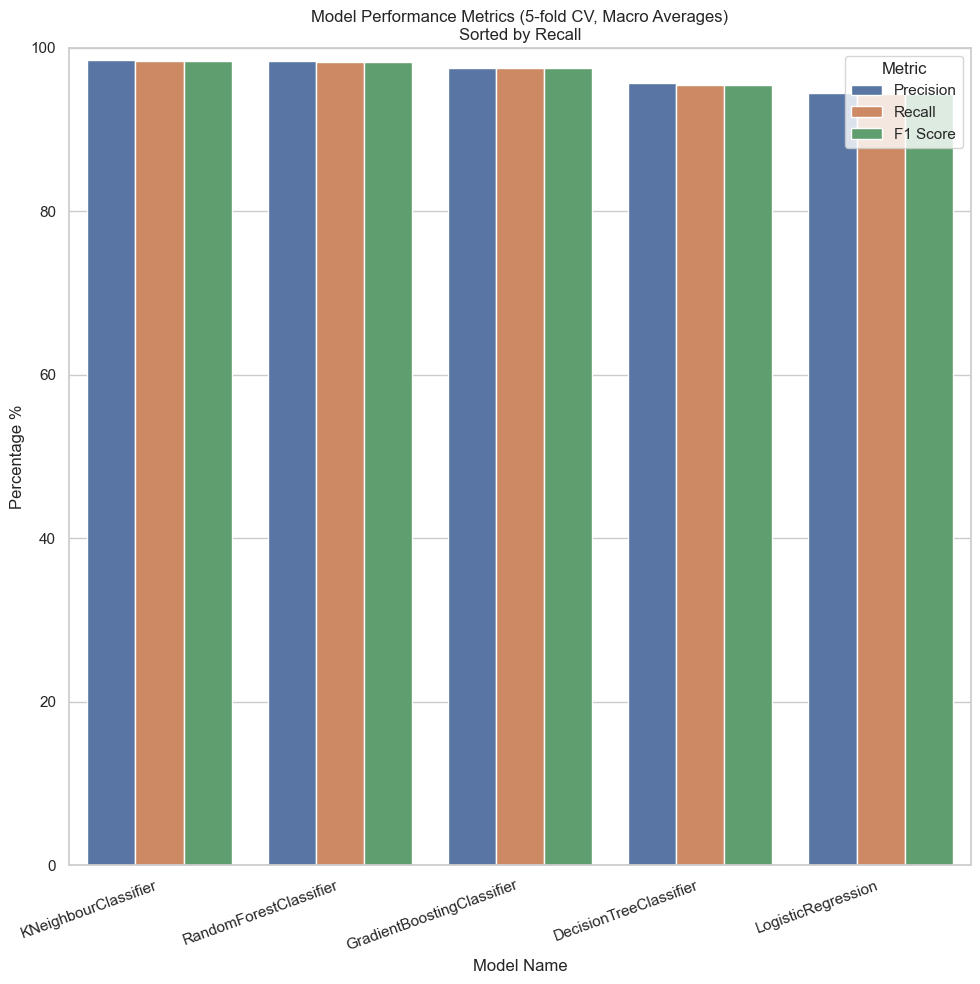

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

order = results_df.sort_values('Recall', ascending=False)['Model']

# Long format for seaborn
results_long = results_df.melt(
    id_vars='Model',
    value_vars=['Precision', 'Recall', 'F1 Score'],
    var_name='Metric',
    value_name='Score'
)

plt.figure(figsize=(10, 10))
sns.barplot(
    data=results_long,
    x='Model',
    y='Score',
    hue='Metric',
    order=order
)

plt.ylabel('Percentage %')
plt.xlabel('Model Name')
plt.title('Model Performance Metrics (5-fold CV, Macro Averages)\nSorted by Recall')
plt.ylim(0, 100)
plt.xticks(rotation=20, ha='right')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


Starting Neural Network Training...
Epoch 10/100 | Train Loss: 0.3036 | Val Loss: 0.2260
Epoch 20/100 | Train Loss: 0.2324 | Val Loss: 0.1625
Epoch 30/100 | Train Loss: 0.1947 | Val Loss: 0.1363
Epoch 40/100 | Train Loss: 0.1743 | Val Loss: 0.1352
Epoch 50/100 | Train Loss: 0.2214 | Val Loss: 0.1309
Epoch 60/100 | Train Loss: 0.1909 | Val Loss: 0.1375
Early stopping at epoch 61

=== Neural Network Final Test Results ===
Accuracy: 0.9333333333333333

Classification Report:
                 precision    recall  f1-score   support

ECG_signal_AFF       0.90      0.82      0.86        45
ECG_signal_ARR       1.00      0.98      0.99        45
ECG_signal_CHF       0.84      0.93      0.88        45
ECG_signal_NSR       1.00      1.00      1.00        45

      accuracy                           0.93       180
     macro avg       0.94      0.93      0.93       180
  weighted avg       0.94      0.93      0.93       180



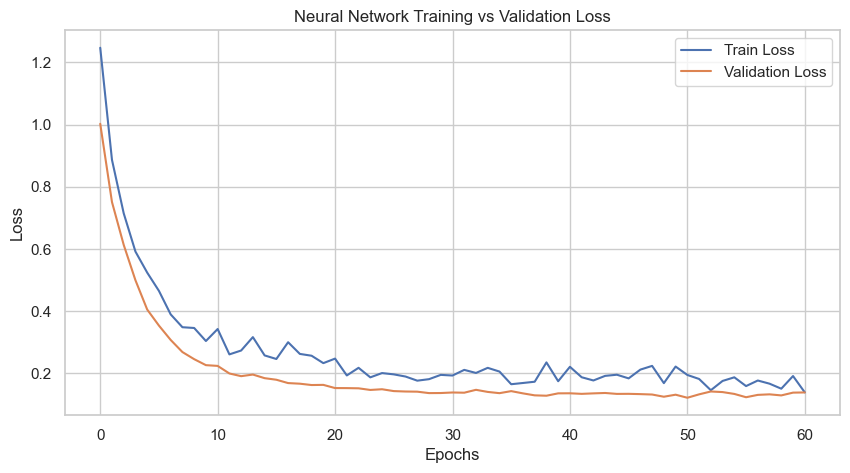

In [ ]:
## Regularized Neural Network (fixed)


import torch.optim as optim

imputer = SimpleImputer(strategy='ßmedian')
X_imputed = imputer.fit_transform(df_encoded[features_final])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)


y_indices = df_encoded[label_cols].values.argmax(axis=1)

# resplitting (run independend)
X_tr, X_temp, y_tr, y_temp = train_test_split(
    X_scaled, y_indices,
    test_size=0.3,
    random_state=42,
    stratify=y_indices
)
X_va, X_te, y_va, y_te = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

# Convert to tensors
train_data = TensorDataset(torch.FloatTensor(X_tr), torch.LongTensor(y_tr))
val_data   = TensorDataset(torch.FloatTensor(X_va), torch.LongTensor(y_va))
test_data  = TensorDataset(torch.FloatTensor(X_te), torch.LongTensor(y_te))


batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=batch_size)
test_loader  = DataLoader(test_data, batch_size=batch_size)

#regularization
class ECGClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ECGClassifier, self).__init__()

        self.layer1   = nn.Linear(input_dim, 64)
        self.bn1      = nn.BatchNorm1d(64)
        self.relu     = nn.ReLU()
        self.dropout1 = nn.Dropout(0.4)    

        self.layer2   = nn.Linear(64, 32)
        self.bn2      = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.3)     
        self.output   = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)

        x = self.layer2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)

        x = self.output(x)
        return x

# Initialize Model
input_dim   = X_tr.shape[1]
num_classes = len(label_cols)  # 4
model = ECGClassifier(input_dim, num_classes).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    model.parameters(),
    lr=0.001,
    weight_decay=1e-4      
)

num_epochs    = 100
best_val_loss = float('inf')
patience      = 10
trigger_times = 0

train_losses = []
val_losses   = []

best_state_dict = None  

print("Starting Neural Network Training...")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:

        optimizer.zero_grad()
        outputs = model(inputs)
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss    = criterion(outputs, labels)
            val_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss   = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss  = avg_val_loss
        trigger_times  = 0
        best_state_dict = model.state_dict() 
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

if best_state_dict is not None:
    model.load_state_dict(best_state_dict)
else:
    print("WARNING: FileNotFoundError")

model.eval()


y_true_test = []
y_pred_test = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs        = model(inputs)
        _, predicted   = torch.max(outputs, 1)

        y_true_test.extend(labels.cpu().numpy())
        y_pred_test.extend(predicted.cpu().numpy())

print("\n=== Neural Network Final Test Results ===")
print("Accuracy:", accuracy_score(y_true_test, y_pred_test))
print("\nClassification Report:\n",
      classification_report(
          y_true_test,
          y_pred_test,
          target_names=label_cols 
      ))


plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Neural Network Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Moral of the story neural network not needed
